In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import networkx as nx
import math
from tqdm import tqdm, trange

# Networked Distributed Optimization with Exogenous Inputs
Consider an $n$-player network game defined on graph structure $\mathcal{G}=(\mathcal{N},\mathcal{E})$, where $\mathcal{N}=\{1,\ldots,n\}$ are the nodes in the graph---one corresponding to each player---and $$\mathcal{E}=\{(i,j)|\ i,j\in \mathcal{N} \ \text{such that}\ i\  \text{is connected to } j\},$$
is the set of edges.

Each player $i\in \mathcal{N}$ collects data and has objective $F_i(x, \xi_i, \xi)$ where $\xi_i\in \Xi_i$ is a random variable with fixed but unknown probability distribution with domain $\Xi_i$ and similarly, $\xi$ is a random variable with fixed but unknown probability distribution with domain $\Xi$. The random variable $\xi_i$ models local environmental fluctuations such as noise. The random variable $\xi$, on the other hand, models a global information state.

In this simulation, we consider a simple Bertrand competition where the players cooperatively seek the social optimum. Each individual has a demand function $D_i(x_i,x_{-i},\xi)$ which is a nonincreasing function of the prices $x_i$ and $x_{-i}$. Each player obtains a revenue $F_i$ where
$$f_i(x_i,x_{-i},\xi) = x_i\cdot D_i(x_i,x_{-i},\xi).$$

Here, we consider a linear demand function where $\xi$ determines the base demand and the price elasticities with respect to each price $x_i$ are given by a vector $\theta\in\mathbb{R}^n$:
$$D_i(x_i,x_{-i},\xi) = \xi + \theta_i^\top x$$

# Generate Communication Network

In [2]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes (Change this to reflect supply chain structure)
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.path_graph(n)  # Generate line graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

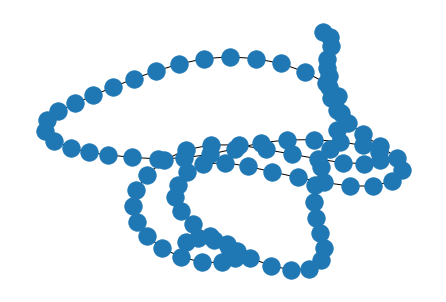

In [3]:
nx.draw(G)

# Problem Parameters

In [4]:
theta_0 = (1/(n+3))*np.ones((n,n))-np.eye(n)
theta = theta_0 + 0.1*np.random.randn(n,n)
print(theta)
xi = n

[[-0.91350762 -0.06106646  0.24826168 ...  0.08136641 -0.10765418
   0.05664135]
 [-0.13801751 -0.8927133  -0.12374619 ...  0.07537083  0.1645
   0.10836823]
 [-0.08011678  0.12527659 -0.95495626 ... -0.09239593 -0.00523658
   0.05007395]
 ...
 [ 0.11776593  0.07187018 -0.01336153 ... -1.12301524  0.03479294
  -0.01458647]
 [ 0.06093554  0.20320766  0.06629442 ... -0.03312967 -1.02568872
  -0.07583762]
 [ 0.1653644   0.01515862  0.12532944 ... -0.10602541 -0.093359
  -1.03010859]]


# Loss and Gradient Oracles

In [5]:
def demand(x,theta,xi):  # calculate demand
    return np.dot(theta,x) + xi

def revenue(x,theta,xi):  # calculate revenue
    return x*demand(x,theta,xi)

def total_revenue(x,theta,xi):  # calculate social revenue
    return np.sum(revenue(x,theta,xi))

def grad_revenue(x,theta,xi):  # gradients wrt individual revenues
    return 2*np.dot(theta,x) + xi

# Centralized GD

100%|█████████████████████████████████████| 5000/5000 [00:00<00:00, 7065.04it/s]


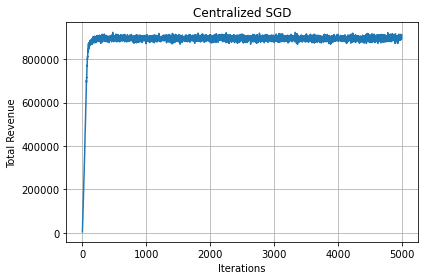

[ 58.04311587   0.         100.         100.          65.85551853
  53.97086955   0.         100.         100.         100.
  73.8959328  100.         100.          38.33027461  51.36328948
 100.         100.         100.         100.          58.10237828
  14.17161072 100.         100.           0.         100.
 100.         100.         100.         100.          43.61474786
 100.         100.          87.83972067 100.         100.
 100.         100.         100.           0.         100.
 100.         100.          64.99098313   0.          64.75095554
   0.         100.          83.00424476 100.         100.
 100.         100.          31.70569797  96.86750593  24.94483656
 100.         100.         100.          43.08605798 100.
  11.64936463  67.99600761 100.         100.         100.
 100.          57.16646223  67.28157963  50.78515792 100.
 100.          96.34536588  70.25336827 100.         100.
  84.70225264 100.         100.         100.         100.
  29.43346656 100.      

In [6]:
x = np.random.rand(n)  # Initialize prices
step = 1e-2  # Step size
p_max = n  # Set maximum price
rev = []
x_hist = []
iterations = 5000

# Run centralized GD
for i in trange(iterations):
    xi = n+np.random.randn(1)
    rev.append(total_revenue(x,theta,xi))
    x_hist.append(x.copy())
    x += step*grad_revenue(x,theta,xi)
    x = np.clip(x,0,p_max)
    
plt.figure()
plt.plot(rev)
plt.grid()
plt.title('Centralized SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/central_sgd.png')
plt.show()

print(x)

In [7]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

# Distributed SGD with synchronous information

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
100%|██████████████████████████████████████| 5000/5000 [00:44<00:00, 112.32it/s]


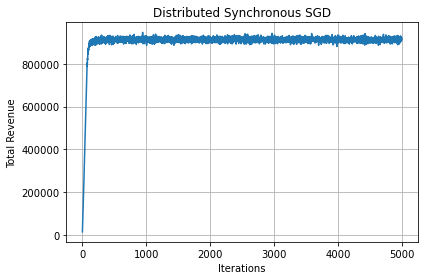

[ 57.88978965   0.         100.         100.          65.67772051
  53.93860273   0.         100.         100.         100.
  73.78961894 100.         100.          38.20333352  51.30993598
 100.         100.         100.         100.          58.02046088
  14.05081727 100.         100.           0.         100.
 100.         100.         100.         100.          43.54395332
 100.         100.          87.78778013 100.         100.
 100.         100.         100.           0.         100.
 100.         100.          64.87979165   0.          64.6561465
   0.         100.          82.95903    100.         100.
 100.         100.          31.68342668  96.7734493   24.95072302
 100.         100.         100.          43.01554885 100.
  11.59898355  67.97076343 100.         100.         100.
 100.          57.23292364  67.2454749   50.70150531 100.
 100.          96.25619221  70.10158334 100.         100.
  84.71251389 100.         100.         100.         100.
  29.37271917 100.       

In [8]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_cent = []
x_hist = []
iterations = 5000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    x_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        X[j] += step*grad_revenue(X[j],theta,xi)
        temp.append(total_revenue(X[j],theta,xi))
    rev_cent.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_cent)
plt.grid()
plt.title('Distributed Synchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_sync.png')
plt.show()

print(np.mean(X,axis=0))

In [9]:
if n==2:
    x_hist = np.array(x_hist)
    plt.figure()
    plt.plot(x_hist[:,0],x_hist[:,1],'-o')
    plt.scatter(x_hist[-1,0],x_hist[-1,1],c='k',zorder=10)
    plt.grid()
    plt.show()

In [10]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.2336246700728326


# Distributed SGD with asynchronous information

100%|██████████████████████████████████████| 5000/5000 [00:46<00:00, 106.46it/s]


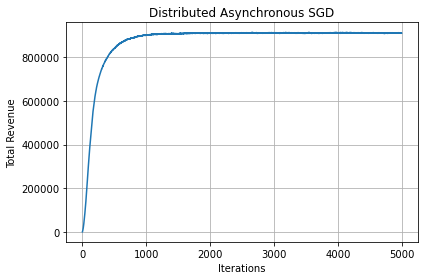

[ 57.83974463   0.         100.         100.          65.63958945
  53.90188458   0.         100.         100.         100.
  73.7438094  100.         100.          38.17081116  51.28410134
 100.         100.         100.         100.          57.99029846
  14.01589512 100.         100.           0.         100.
 100.         100.         100.         100.          43.49565351
 100.         100.          87.74464879 100.         100.
 100.         100.         100.           0.         100.
 100.         100.          64.84049082   0.          64.63243838
   0.         100.          82.92730151 100.         100.
 100.         100.          31.6542906   96.73868924  24.91058821
 100.         100.         100.          42.97833066 100.
  11.55580191  67.93472881 100.         100.         100.
 100.          57.19167499  67.20037808  50.66349209 100.
 100.          96.22957072  70.0735458  100.         100.
  84.67209505 100.         100.         100.         100.
  29.3350516  100.      

In [11]:
P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 5000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if not G.nodes[node]['informed']:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
        else:
            G.nodes[node]['xi'] = xi
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_async.png')
plt.show()

print(np.mean(X,axis=0))

In [12]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.4361940629700305


# Fully connected graph

100%|███████████████████████████████████████| 5000/5000 [01:15<00:00, 66.50it/s]


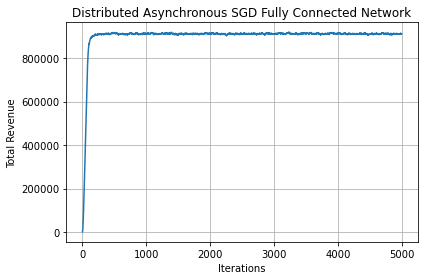

[ 57.8222921    0.         100.         100.          65.61375139
  53.90564958   0.         100.         100.         100.
  73.73257648 100.         100.          38.15315411  51.2793947
 100.         100.         100.         100.          57.9798735
  14.00159648 100.         100.           0.         100.
 100.         100.         100.         100.          43.49690553
 100.         100.          87.74405262 100.         100.
 100.         100.         100.           0.         100.
 100.         100.          64.8278994    0.          64.62418356
   0.         100.          82.92517708 100.         100.
 100.         100.          31.6568734   96.73010828  24.92274822
 100.         100.         100.          42.97429761 100.
  11.5563709   67.93848452 100.         100.         100.
 100.          57.21496023  67.20557113  50.65867486 100.
 100.          96.22081116  70.04890719 100.         100.
  84.68490726 100.         100.         100.         100.
  29.33456497 100.        

In [13]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.complete_graph(n)  # Generate complete graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 5000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Fully Connected Network')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_fc.png')
plt.show()

print(np.mean(X,axis=0))

In [14]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.5000397890372165


# Erdos Renyi random graph p=0.2

100%|███████████████████████████████████████| 5000/5000 [00:56<00:00, 87.82it/s]


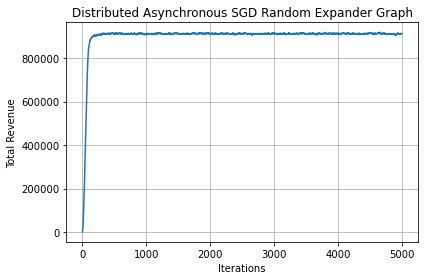

[ 57.74240012   0.         100.         100.          65.52336762
  53.90710848   0.         100.         100.         100.
  73.68180565 100.         100.          38.09555976  51.26902931
 100.         100.         100.         100.          57.94927712
  13.94809925 100.         100.           0.         100.
 100.         100.         100.         100.          43.47432819
 100.         100.          87.72769278 100.         100.
 100.         100.         100.           0.         100.
 100.         100.          64.77724214   0.          64.59832168
   0.         100.          82.91707781 100.         100.
 100.         100.          31.66580589  96.69577621  24.94848112
 100.         100.         100.          42.95209846 100.
  11.54108976  67.94259276 100.         100.         100.
 100.          57.27405429  67.20126479  50.62987733 100.
 100.          96.19334949  69.9754063  100.         100.
  84.7114212  100.         100.         100.         100.
  29.31988949 100.      

In [15]:
n = 100  # Number of nodes
n_i = 5  # Number of informed nodes

N_i = np.random.choice(n, size=n_i)  # Randomly select n_i informed nodes
N = np.zeros(n, dtype=bool)  # Set of n nodes, initialized to False (uninformed)
N[N_i] = True  # Set informed node indices to True (informed)

G = nx.erdos_renyi_graph(n, p=0.2)  # Generate random graph from the nodes in N

attribute_dict = {}  # generate dictionary to add informed status as attribute to each node
for node in G.nodes:
    attribute_dict[node] = {'informed': N[node], 'xi': np.random.randn(1)}  
    
nx.set_node_attributes(G, attribute_dict)  # set attributes for each node

P = nx.laplacian_matrix(G).toarray()
P = np.eye(n) - (1/(1+np.max(np.diagonal(P))))*P  # Define doubly stochastic mixing matrix from Laplacian

X = np.random.rand(n,n)

step = 1e-2  # Step size
p_max = n  # Set maximum price
rev_dist = []
x_dist_hist = []
iterations = 5000

for i in trange(iterations):
    xi = n+np.random.randn(1)
    for node in range(n):
        if G.nodes[node]['informed']:
            G.nodes[node]['xi'] = xi
        else:
            xi_lst = []
            for neig in G.neighbors(node):
                xi_lst.append(G.nodes[neig]['xi'])
            G.nodes[node]['xi'] = sum(xi_lst)/len(xi_lst)
    x_dist_hist.append(X.copy().T)
    X = np.dot(P,X)
    temp = []
    for j in range(n):
        xi_j = G.nodes[j]['xi']
        X[j] += step*grad_revenue(X[j],theta,xi_j)
        temp.append(total_revenue(X[j],theta,xi_j))
    rev_dist.append(sum(temp)/len(temp))
    X = np.clip(X,0,p_max)
    
plt.figure()
plt.plot(rev_dist)
plt.grid()
plt.title('Distributed Asynchronous SGD Random Expander Graph')
plt.xlabel('Iterations')
plt.ylabel('Total Revenue')
plt.tight_layout()
plt.savefig('./figures/dist_sgd_expander.png')
plt.show()

print(np.mean(X,axis=0))

In [16]:
print(f'error = {la.norm(x-np.mean(X,axis=0))**2}')

error = 0.8259967323142918
